In [2]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
import cartopy.feature as cfeature
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps

import metpy


class goes_data(object):
    """docstring for goes_data."""

    def __init__(self, filename, variable_to_plot, extent, resolution_of_plot):
        self.filename = filename
        self.x_points = None
        self.y_points = None
        self.resolution_of_plot = resolution_of_plot
        self.variable_to_plot = variable_to_plot
        self.goes_sat_data = None
        self._cmap_to_goes_plot = 'cmap_goes_sat/IR4AVHRR6.cpt'
        self._cmap_convert_cpt = None
        self._cmap = None
        self.states_provinces = None
        self.geopolitics_boundaries = None
        self.extent_of_plot = {'lonmin':extent[0], 'lonmax':extent[1],
                               'latmin':extent[2], 'latmax':extent[3]}
        self._cartopy_projection = ccrs.PlateCarree()
        self._satelite_projection = None
        self.variable_to_plot_data = None
        ax = None
        self.figure = None
        self.datetime = None

    def _generate_cmap(self):
        self._cmap_convert_cpt = loadCPT(self._cmap_to_goes_plot)
        self._cmap = LinearSegmentedColormap('cpt', self._cmap_convert_cpt)

    def read_satelite_data(self):
        self.goes_sat_data = xarray.open_dataset(self.filename)


    def _get_datetime(self):
        self.datetime= self.goes_sat_data.attrs['date_created']

    def get_variable_to_plot(self):
        try:
            self.variable_to_plot_data = self.goes_sat_data[self.variable_to_plot].data
            self.variable_plot = self.goes_sat_data.metpy.parse_cf(self.variable_to_plot)
            self.variable_goes_to_projection = self.variable_plot.metpy.cartopy_crs
        except KeyError as msg:
            print("Variable name may be not correct")
            exit()

    def _get_coordinates_from_goes_satelite(self):
        self.x_points = self.variable_plot.x
        self.y_points = self.variable_plot.y

    def get_plot_from_VIS_band(self, name_of_fig):
        self._get_coordinates_from_goes_satelite()
        self._generate_cmap()
        self._get_datetime()
        self.figure = plt.figure(figsize=(15, 15))
        ax = plt.axes(projection=self._cartopy_projection)

        ax.set_extent([self.extent_of_plot['lonmin'], self.extent_of_plot['lonmax'],
                                  self.extent_of_plot['latmin'], self.extent_of_plot['latmax']],
                                  crs=self._cartopy_projection)

        ax.imshow(self.variable_to_plot_data[::self.resolution_of_plot, ::self.resolution_of_plot], origin='upper',
                       extent=(self.x_points.min(), self.x_points.max(), self.y_points.min(), self.y_points.max()),
                       transform=self.variable_goes_to_projection,
                       interpolation='none', vmin=0, vmax=1, cmap='gray')

        ax.set_title('GOES-16', loc='left', fontweight='bold')
        ax.set_title(self.datetime, loc='right', fontweight='bold')
        ax.coastlines(resolution='50m', linewidth=.75)

        ''' custom shapeline has a bug on cartopy, don't use it '''
        states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                              name='admin_1_states_provinces_shp')
        
        _ = ax.add_feature(states, edgecolor='blue')


        plt.show()
    def get_plot_from_IR_band(self, name_of_fig):
        self._get_coordinates_from_goes_satelite()
        self._generate_cmap()
        self._get_datetime()
        self.figure = plt.figure(figsize=(15, 15))
        ax = plt.axes(projection=self._cartopy_projection)

        ax.set_extent([self.extent_of_plot['lonmin'], self.extent_of_plot['lonmax'],
                              self.extent_of_plot['latmin'], self.extent_of_plot['latmax']],
                              crs=self._cartopy_projection)

        ax.imshow(self.variable_to_plot_data[::self.resolution_of_plot, ::self.resolution_of_plot], origin='upper',
                   extent=(self.x_points.min(), self.x_points.max(), self.y_points.min(), self.y_points.max()),
                   transform=self.variable_goes_to_projection,
                   interpolation='none', cmap=self._cmap, vmin=170, vmax=378)

        ax.set_title('GOES-16', loc='left', fontweight='bold')
        ax.set_title(self.datetime, loc='right', fontweight='bold')
        
        ''' custom shapeline has a bug on cartopy, don't use it '''
        states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
        
        _ = ax.add_feature(states, edgecolor='blue')

        plt.show()

        # to save a fig, just add plt.savefig....
        #plt.savefig(name_of_fig, DPI=300)


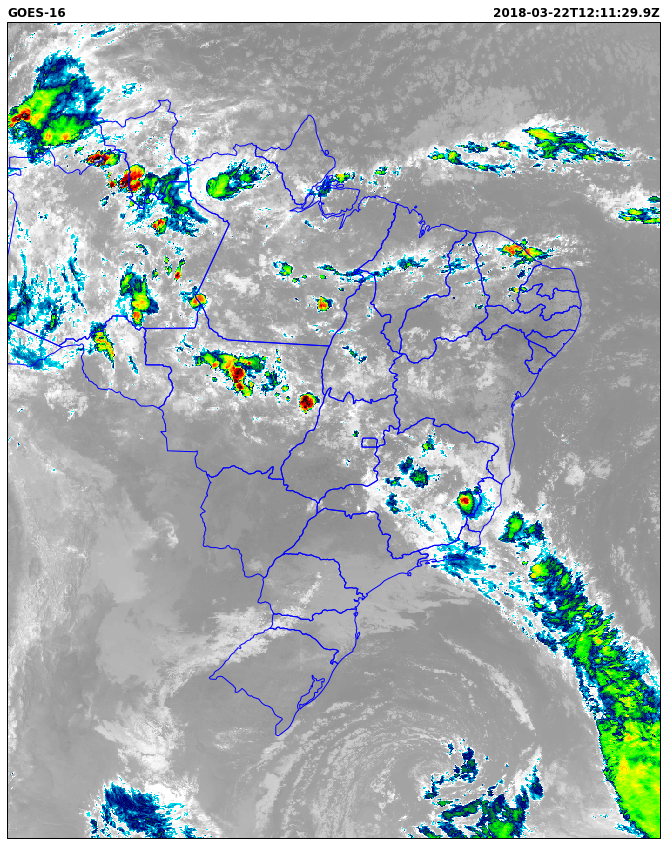

In [4]:
lonmin = -70
latmin = -40
lonmax = -30
latmax = 10
filename= '/Users/pmello/goes16/2018/03/22/ABI-L2-CMIPF/12/C13/OR_ABI-L2-CMIPF-M3C13_G16_s20180811200448_e20180811211227_c20180811211299.nc'
goes_sat = goes_data(filename,
                     'CMI', [lonmin, lonmax, latmin, latmax], 2)
goes_sat.read_satelite_data()
goes_sat.get_variable_to_plot()
goes_sat.get_plot_from_IR_band('teste.png')